# Imports

In [1]:
from sms_norm import normalize_and_hash_series, dedupe_by_hash
from sms_embed import embed_dedup_dataframe, save_embeddings, load_embeddings
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import umap.umap_ as umap
import hdbscan
from plots import *
from sklearn.preprocessing import normalize
import joblib
import importlib
import os
import umap
import hdbscan
from plots import plot_campaigns

# Normalize and embed

In [2]:
# Load the ready-made synthetic data
df_raw = pd.read_csv("./artifacts/synthetic_one_originator.csv")  

# Normalize + dedupe
norm = normalize_and_hash_series(df_raw["raw_text"], seed=0)
norm.insert(0, "originator_id", df_raw["originator_id"])
norm.insert(1, "message_id", df_raw["message_id"])
dedup_df, _ = dedupe_by_hash(norm)

# Embed (offline MiniLM) and save CSV+NPY
LOCAL_MODEL = r"C:/models/all-MiniLM-L6-v2"  # local model folder

meta_df, X = embed_dedup_dataframe(
    dedup_df, text_col="normalized_text", id_col="template_hash_xx64",
    batch_size=64, normalize=True, model_name=LOCAL_MODEL
)
csv_path, npy_path = save_embeddings(meta_df, X, out_dir="./artifacts", prefix="week_synth")
print("Saved:", csv_path, npy_path)

Saved: ./artifacts\week_synth.csv ./artifacts\week_synth.npy


# UMAP+HDBSCAN, save cetroids + exemplars (LLM for campaign name) 

In [3]:
# --- Cell: build reference, compute centroids, nearest samples, call LLM, persist ---
import os
import numpy as np
import pandas as pd
import joblib
import umap
import hdbscan
from datetime import datetime
from typing import Any, Dict


ART_DIR   = "./artifacts"
PREFIX    = "week_synth"  # from save_embeddings(...)
META_CSV  = os.path.join(ART_DIR, f"{PREFIX}.csv")
VEC_NPY   = os.path.join(ART_DIR, f"{PREFIX}.npy")

assert os.path.exists(META_CSV) and os.path.exists(VEC_NPY), "Run Stage 4 first to create CSV+NPY."

# local helpers (write these files next to the notebook)
from llm_client import summarize_samples
from persist_utils import save_campaign_footprint

# PARAMETERS
N_NEAREST = 5              # take top K = min(N_NEAREST, cluster_size)
UMAP_PARAMS: Dict[str, Any] = dict(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
    force_approximation_algorithm=False,
    transform_seed=42,
)

HDBSCAN_PARAMS: Dict[str, Any] = dict(
    min_cluster_size=5,
    min_samples=2,
    metric="euclidean",
)

# Load meta + embeddings
meta = pd.read_csv(META_CSV, encoding="utf-8")
X = np.load(VEC_NPY)  # shape [M, D]

# Safety: ensure unit-norm (cosine-ready)
X = X.astype(np.float32)
X = X / np.maximum(np.linalg.norm(X, axis=1, keepdims=True), 1e-12)

# UMAP to 2D (for visualization only)
umap_model = umap.UMAP(**UMAP_PARAMS)
X_2d = umap_model.fit_transform(X)
joblib.dump(umap_model, os.path.join(ART_DIR, "umap_model.pkl"))

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(**HDBSCAN_PARAMS)
labels = clusterer.fit_predict(X)

# attach labels into meta so saved points include label column
meta = meta.copy()
meta["label"] = labels

unique, counts = np.unique(labels, return_counts=True)
print("Cluster counts:")
for k, v in zip(unique, counts):
    print(f"  C{k:>3}: {v:>5d}")

# Compute centroids and select exemplars (nearest samples)
cluster_labels = sorted([c for c in set(labels) if c != -1])
centroids = []
campaign_rows = []
examples_rows = []  # will hold campaign_examples (one row per exemplar)
for row_idx, cl in enumerate(cluster_labels):
    member_idx = np.where(labels == cl)[0]
    if member_idx.size == 0:
        continue
    # centroid in original embedding space (384-D), unit-norm
    cvec = X[member_idx].mean(axis=0)
    cvec = cvec / (np.linalg.norm(cvec) + 1e-12)
    centroids.append(cvec.astype(np.float32))

    # sims & ordering (cosine because unit-norm)
    sims = X[member_idx] @ cvec
    order = np.argsort(-sims)
    ordered_idx = member_idx[order]

    k = min(N_NEAREST, ordered_idx.size)
    top_idx = ordered_idx[:k]

    # collect exemplars rows
    for rank, global_i in enumerate(top_idx, start=1):
        sim_value = float(sims[order][rank-1])  # matches rank order
        examples_rows.append({
            "campaign_row_index": row_idx,
            "campaign_label": int(cl),
            "rank": int(rank),
            "message_id": meta.iloc[global_i].get("message_id", ""),
            "template_hash_xx64": meta.iloc[global_i].get("template_hash_xx64", ""),
            # Prefer normalized_text (masked). Use raw_text only if you understand privacy/PII.
            "text_sample": meta.iloc[global_i].get("normalized_text", meta.iloc[global_i].get("raw_text", "")),
            "sim_score": sim_value,
            "count_in_window": int(meta.iloc[global_i].get("count_in_window", 1))
        })

    # campaign-level metadata
    proto_count = int(member_idx.size)
    msg_count = int(meta.iloc[member_idx]["count_in_window"].sum()) if "count_in_window" in meta.columns else proto_count
    # date range: try to use timestamp fields if present else use current build date
    if {"window_start", "window_end"}.issubset(meta.columns):
        dr_start = meta.iloc[member_idx]["window_start"].min()
        dr_end = meta.iloc[member_idx]["window_end"].max()
    elif {"timestamp"}.issubset(meta.columns):
        dr_start = meta.iloc[member_idx]["timestamp"].min()
        dr_end = meta.iloc[member_idx]["timestamp"].max()
    else:
        dr_start = dr_end = datetime.utcnow().isoformat()

    campaign_rows.append({
        "row_index": row_idx,                   # index into centroids array
        "cluster_label": int(cl),               # original HDBSCAN label
        "proto_count": proto_count,
        "msg_count": msg_count,
        "date_range_start": dr_start,
        "date_range_end": dr_end,
        "campaign_name": "",                    # filled later by LLM/human
        "status": "Known"
    })

# Stack centroids
if len(centroids) > 0:
    C = np.vstack(centroids)
else:
    C = np.zeros((0, X.shape[1]), dtype=np.float32)

# Call LLM summarizer for each campaign using the nearest samples (deterministic)
campaigns_df = pd.DataFrame(campaign_rows)
examples_df = pd.DataFrame(examples_rows)

# For each campaign_row_index gather sorted samples and call LLM
campaign_names = []
for row in campaigns_df.itertuples(index=False):
    row_idx = int(row.row_index) # type: ignore
    samples = examples_df[examples_df["campaign_row_index"] == row_idx].sort_values("rank")["text_sample"].tolist()
    # Ensure samples are masked/normalized. summarize_samples will double-check.
    if len(samples) == 0:
        summary = ""
        raw_resp = None
    else:
        # Use the llm_client default model (gpt-4o-mini) or specify explicitly
        summary, raw_resp = summarize_samples(samples, max_words=5, model="gpt-4o-mini", temperature=0.0)
    campaign_names.append(summary or "")

campaigns_df["campaign_name"] = campaign_names

# Persist everything using helper (creates campaigns.csv, campaigns.npy, campaign_examples.csv, points.csv)
save_campaign_footprint(
    out_dir=ART_DIR,
    prefix=PREFIX,
    campaigns_df=campaigns_df,
    centroids=C,
    campaign_examples_df=examples_df,
    points_meta=meta,
    points_2d=X_2d, # type: ignore
)

print("Reference build complete. Artifacts saved under:", ART_DIR)


dotenv load error: No module named 'dotenv'


C:\Users\eliei\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\eliei\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\eliei\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\eliei\AppData\Local\Temp\ipykernel_144124\873737147.py:114: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  dr_start = dr_end = datetime.utcnow().isoformat()


Cluster counts:
  C -1:     3
  C  0:     5
  C  1:     6
  C  2:     6
  C  3:     6
  C  4:    11
Saved artifacts:
 - campaigns_csv: ./artifacts\week_synth_campaigns.csv
 - centroids_npy: ./artifacts\week_synth_campaign_centroids.npy
 - campaign_examples_csv: ./artifacts\week_synth_campaign_examples.csv
 - points_csv: ./artifacts\week_synth_points.csv
Reference build complete. Artifacts saved under: ./artifacts


# Plot UMAP

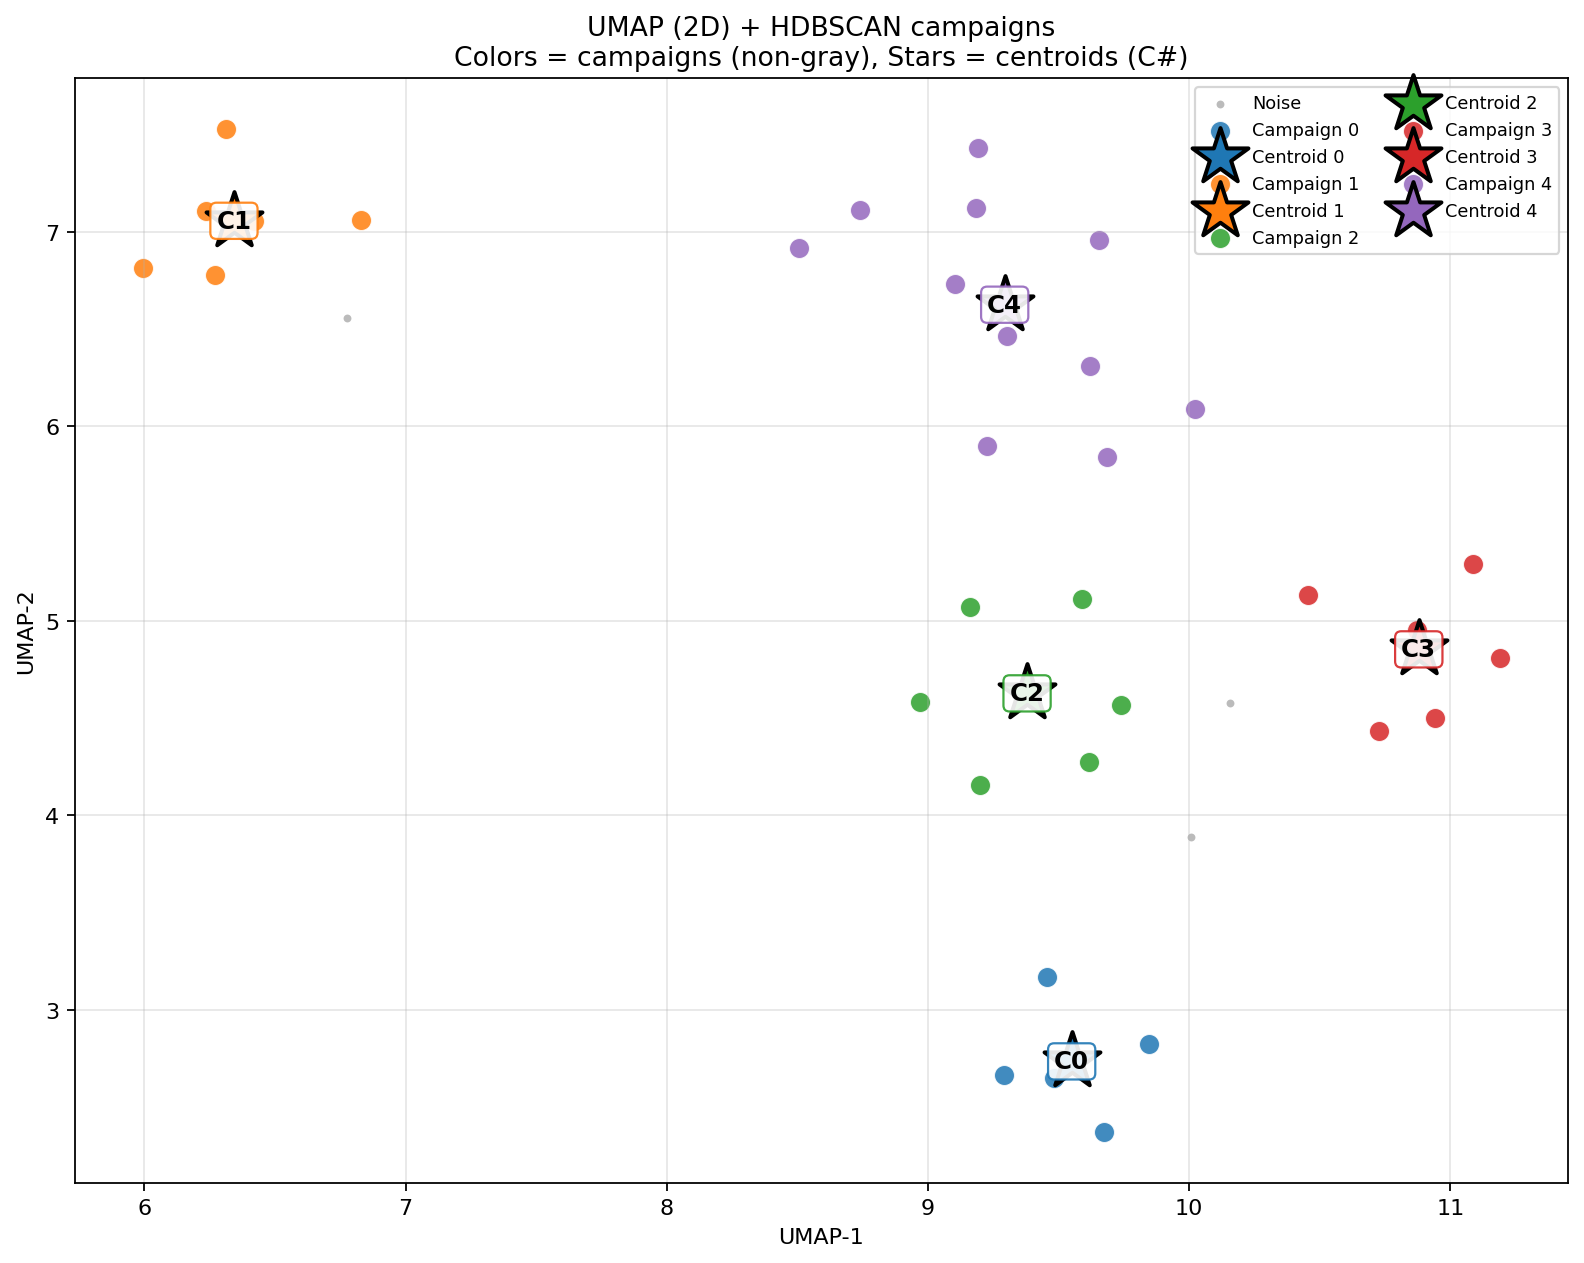

 - plot          : ./artifacts\umap_hdbscan_campaigns.png


In [8]:
plot_path     = os.path.join(ART_DIR, "umap_hdbscan_campaigns.png")
cluster_ids = campaigns_df["cluster_label"].tolist()
plot_campaigns(X_2d, labels, cluster_ids, plot_path)
print(" - plot          :", plot_path)

# Treat new data and rank it

In [ ]:
# Distance-based drift (0–1)
# Outputs:
#   A_tuple (GLOBAL): (mean_distance, std_distance, noise_rate, global_drift, alpha, tau_d)
#   B_tuple (PER-CAMPAIGN): ([(campaign_row, campaign_label, mean_distance_c, std_distance_c, n_c), ...], macro_mean_distance)


# --- Paths ---
REF_CENTROIDS_PATH = "./artifacts/campaigns.npy"      # 384-D centroids (K, D)
REF_CENTROIDS_MAP  = "./artifacts/campaigns.csv"      # row_index -> cluster_label
#NEW_MESSAGES_CSV_PATH = "./artifacts/syntheric_one_originator_new_data.csv"  # raw_text only
NEW_MESSAGES_CSV_PATH = "./artifacts/mixed_160_orig__40_new.csv"  # raw_text only
#NEW_MESSAGES_CSV_PATH = "./artifacts/synthetic_one_originator.csv"  # raw_text only


# --- Embedding model ---
LOCAL_MODEL = r"C:/models/all-MiniLM-L6-v2"   # offline MiniLM

# --- Drift params ---
tau_d = 0.20   # distance threshold for "noise" (1 - cosine > tau_d)
alpha = 0.70   # blend for GlobalDrift

# --- helper ---
def _row_l2_normalize(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    nrm = np.linalg.norm(X, axis=1, keepdims=True)
    nrm = np.maximum(nrm, eps)
    return X / nrm

# 1) Load new data (raw_text)
df_raw = pd.read_csv(NEW_MESSAGES_CSV_PATH)

# 2) Normalize + dedupe
norm = normalize_and_hash_series(df_raw["raw_text"], seed=0)
dedup_df, _ = dedupe_by_hash(norm)

# 3) Embed (unit-norm)
meta_df, X = embed_dedup_dataframe(
    dedup_df, text_col="normalized_text", id_col="template_hash_xx64",
    batch_size=64, normalize=True, model_name=LOCAL_MODEL
)

# 4) Load 384-D centroids (+ mapping row_index → cluster_label)
C = np.load(REF_CENTROIDS_PATH)
C = _row_l2_normalize(C)

cmap_df = pd.read_csv(REF_CENTROIDS_MAP).sort_values("row_index")
centroid_labels = cmap_df["cluster_label"].to_numpy(dtype=int)   # ← array, not dict

# 5) Distances to nearest centroid (0–1) and assignments
cos = X @ C.T
s_max = cos.max(axis=1)
a_idx = cos.argmax(axis=1)            # nearest centroid *row* in campaigns.npy
d = 1.0 - s_max
noise_mask = d > tau_d

# -------------------------
# A) GLOBAL METRICS & RANK
# -------------------------
mean_d = float(d.mean()) if len(d) else float("nan")
std_d  = float(d.std(ddof=0)) if len(d) else float("nan")
noise_rate = float(noise_mask.mean()) if len(d) else float("nan")
global_drift = alpha * mean_d + (1.0 - alpha) * noise_rate

# >>> A_tuple (GLOBAL) <<<
# (mean_distance, std_distance, noise_rate, global_drift, alpha, tau_d)
A_tuple = (mean_d, std_d, noise_rate, global_drift, alpha, tau_d)

# -----------------------------------
# B) PER-CAMPAIGN METRICS
# -----------------------------------
covered = ~noise_mask
covered_idx = np.where(covered)[0]
per_campaign = []  # (campaign_row, campaign_label, mean_distance_c, std_distance_c, n_c)

if covered_idx.size > 0:
    a_cov = a_idx[covered_idx]
    d_cov = d[covered_idx]
    for c_row in np.unique(a_cov):
        mask_c = (a_cov == c_row)           # shape == len(covered_idx)
        d_c = d_cov[mask_c]                 # <-- FIX: index the covered distances, not full d
        mu_c = float(d_c.mean())
        sd_c = float(d_c.std(ddof=0))
        n_c  = int(mask_c.sum())
        c_lab = int(centroid_labels[c_row]) if centroid_labels is not None else int(c_row)
        per_campaign.append((int(c_row), c_lab, mu_c, sd_c, n_c))
    macro_mean = float(np.mean([m[2] for m in per_campaign])) if per_campaign else float("nan")
else:
    macro_mean = float("nan")

# >>> B_tuple (PER-CAMPAIGN) <<<
# ( [ (campaign_row, campaign_label, mean_distance_c, std_distance_c, n_c), ... ], macro_mean_distance )
B_tuple = (per_campaign, macro_mean)

# --- Optional prints ---
print("A_tuple (GLOBAL):", A_tuple)
print("B_tuple sample (first 5):", per_campaign[:5], "macro_mean_distance:", macro_mean)


A_tuple (GLOBAL): (0.34400537610054016, 0.23378057777881622, 0.5227272727272727, 0.3976219450885599, 0.7, 0.2)
B_tuple sample (first 5): [(0, 0, 0.17731104791164398, 0.015458750538527966, 3), (1, 1, 0.11587829887866974, 0.02580842562019825, 5), (2, 2, 0.16775667667388916, 0.0019995809998363256, 6), (4, 4, 0.13961844146251678, 0.05243673175573349, 7)] macro_mean_distance: 0.15014111623167992


# debug plot of new data

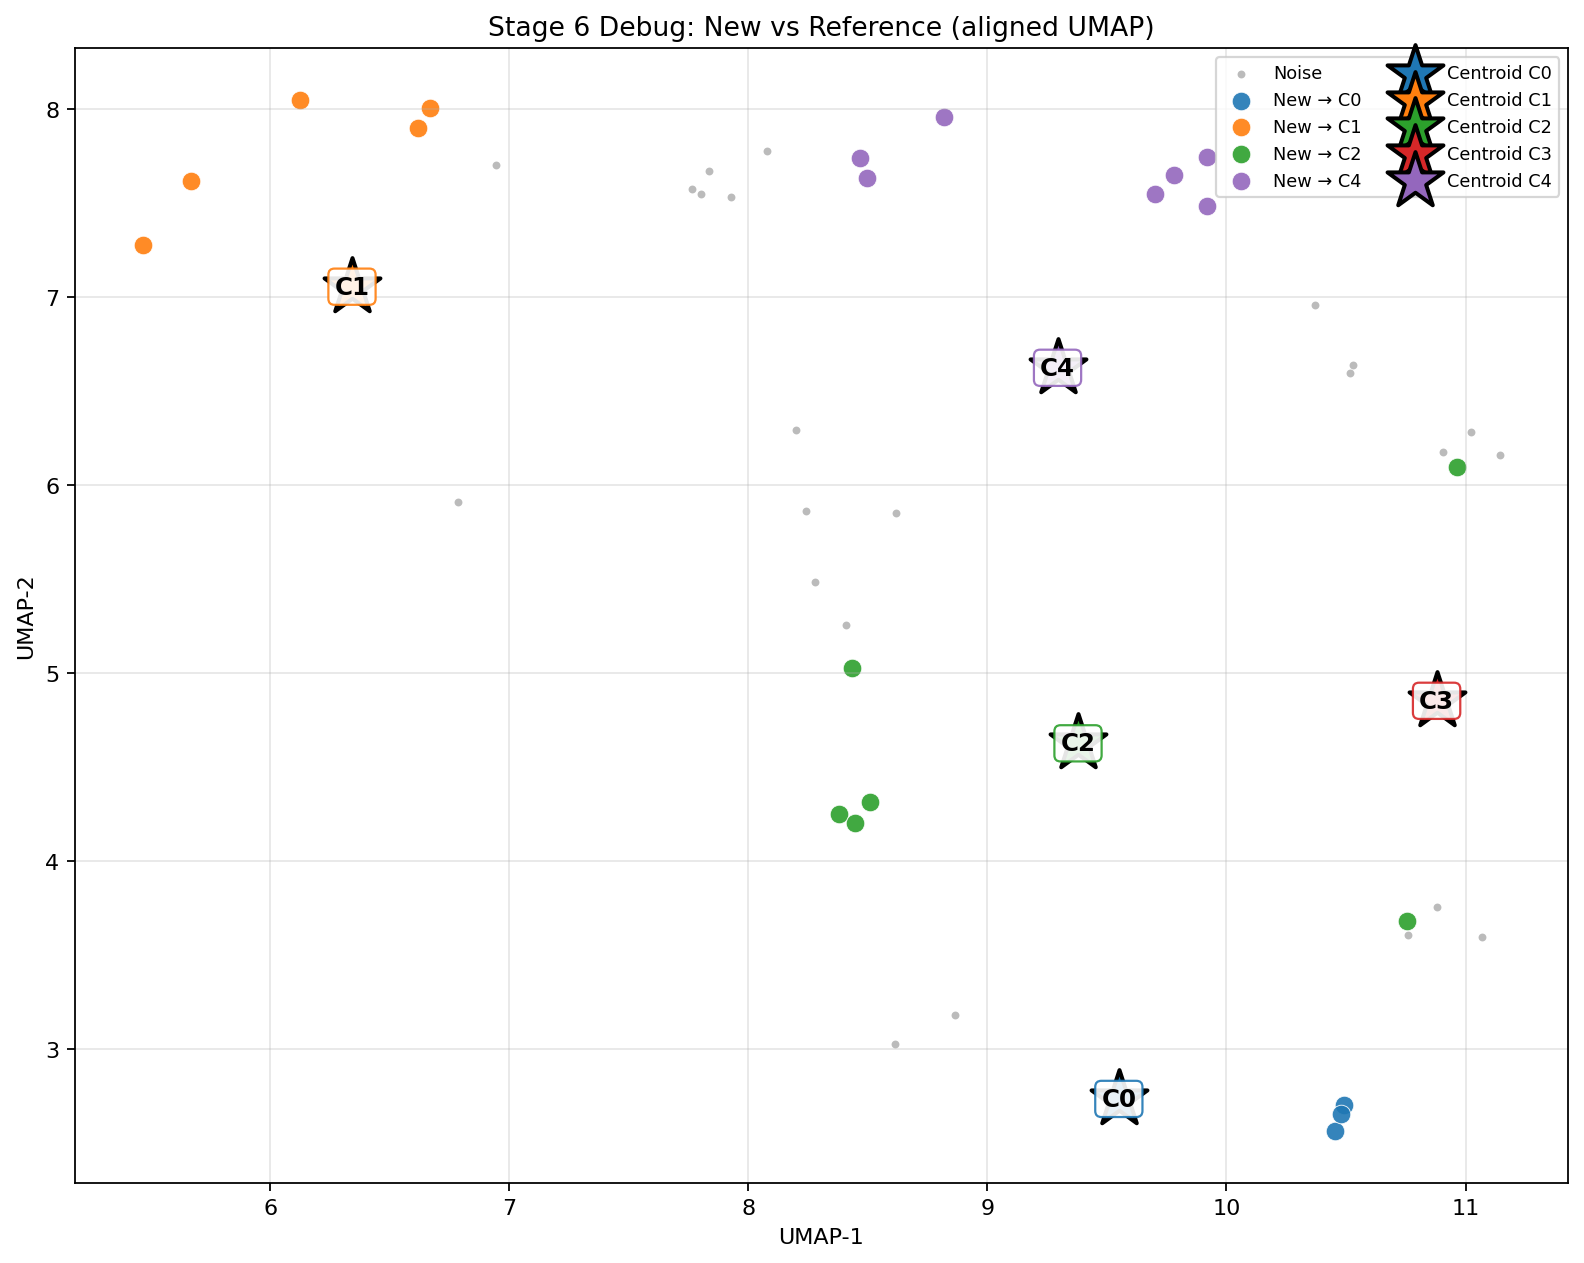

In [11]:
# Debug plot (aligned with Stage 5 UMAP) ===
# - Uses saved reducer (umap_model.pkl) with deterministic transform
# - Stars = mean of saved 2D coords (points.csv)
# - New points: colored by assigned centroid's LABEL; noise in gray


# load artifacts
umap_model = joblib.load("./artifacts/umap_model.pkl")          # same reducer from Stage 5
points_df  = pd.read_csv("./artifacts/points.csv")              # has 'umap_x','umap_y','label'
X_ref      = np.load("./artifacts/week_synth.npy")              # optional (not used if X_ref_2d passed)
X_ref_2d   = points_df[["umap_x","umap_y"]].to_numpy()
ref_labels = points_df["label"].to_numpy()

# row -> label mapping (used to color new points by campaign label)
cmap_df = pd.read_csv("./artifacts/campaigns.csv").sort_values("row_index")
centroid_labels = cmap_df["cluster_label"].to_numpy(dtype=int)

# plotting function (reloaded to ensure latest version with X_ref_2d=)
import plots
importlib.reload(plots)
from plots import plot_ref_stars_mean2d_with_new

# call the plotter (reuses a_idx, noise_mask, C, X from Cell 1)
plot_ref_stars_mean2d_with_new(
    reducer=umap_model,
    X_ref=X_ref,                 # not used if X_ref_2d provided; kept for API symmetry
    ref_labels=ref_labels,
    C=C,
    X_new=X,
    a_idx=a_idx,
    noise_mask=noise_mask,
    centroid_labels=centroid_labels,
    X_ref_2d=X_ref_2d,           # ensures stars match Stage-5 exactly
    title="Stage 6 Debug: New vs Reference (aligned UMAP)",
    save_path="./artifacts/stage6_debug_umap.png",
)


In [15]:
# reload plots if has changed
import importlib
import plots
importlib.reload(plots)

from plots import plot_ref_stars_mean2d_with_new
from sms_norm import normalize_and_hash_series, dedupe_by_hash
from sms_embed import embed_dedup_dataframe, save_embeddings, load_embeddings
import numpy as np